<a href="https://colab.research.google.com/github/rjpower/alphafold_finetune/blob/main/MHC_Peptide_Search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Setup -- get datasets and install BioPython

!test -f /tmp/maria.zip || curl -L 'https://drive.google.com/u/0/uc?id=1pNRhOKl98uNJ9G6z8v1mmnALLN97zg6T&export=download' > /tmp/maria.zip

!pip install biopython pandas seaborn

In [2]:
from Bio import Align
from Bio.Align import substitution_matrices

import seaborn as sns
import tqdm
import pandas as pd
import glob
import zipfile
import os
import os.path
import numpy as np

In [3]:
frames = []
with zipfile.ZipFile('/tmp/maria.zip') as zf:
    for name in zf.namelist():
        if name.endswith('.csv'):
            with zf.open(name) as f:
                df = pd.read_csv(f)
                patient_file = name[name.find('Combined_results_') + len('Combined_results_'):-len('.csv')]
                if not 'stripped' in df:
                    df['stripped'] = df['Pep_short']

                df['patient_file'] = patient_file
                mhc_idx = patient_file.find('MHC')
                df['mhc'] = patient_file[mhc_idx:mhc_idx+4]
                df['patient_id'] = patient_file[:mhc_idx-1]


                frames.append(df)

dataset = pd.concat(frames)
dataset['stripped'] = dataset['stripped'].astype(str)
dataset

,SpecID,Label,Scanf,SP_flg,TR_flg,Ribo_flg,DE_flg,PH_flg,CY_flg,OX_flg,...,Proteins,Pep_short,Q_value,PEP_sore,Algo,stripped,patient_file,mhc,patient_id,Total
0,target_11640_11877_3_1,0.0,11640.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,sp|P53634|CATC|1,YDHNFVKAINAIQKS,0.00000,9.250000e-11,sequest,YDHNFVKAINAIQKS,MCL034_MHC2_rep2,MHC2,MCL034,NaN
1,target_11097_11877_3_1,0.0,11097.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,sp|P53634|CATC|1,YDHNFVKAINAIQK,0.00000,1.820000e-10,sequest,YDHNFVKAINAIQK,MCL034_MHC2_rep2,MHC2,MCL034,NaN
2,target_14028_11877_2_1,0.0,14028.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,sp|P61769|B2MG|1,LLYYTEFTPTEKDE,0.00000,3.010000e-10,sequest,LLYYTEFTPTEKDE,MCL034_MHC2_rep2,MHC2,MCL034,NaN
3,target_12077_11877_2_1,0.0,12077.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,sp|P15311|EZRI|1,AELEFAIQPNTTGKQ,0.00000,3.600000e-10,sequest,AELEFAIQPNTTGKQ,MCL034_MHC2_rep2,MHC2,MCL034,NaN
4,target_18386_11877_2_1,0.0,18386.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,sp|Q9NPH3|IL1AP|1,LPGGIVTDETLSFIQK,0.00000,4.250000e-10,sequest,LPGGIVTDETLSFIQK,MCL034_MHC2_rep2,MHC2,MCL034,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2596,target_4737_11800_3_1,0.0,4737.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,sp|P01833|PIGR|1,NaN,0.01105,3.453000e-01,sequest,DQADGSRASVDSGSSEEQGGSSRALVS,MCL001_MHC2,MHC2,MCL001,NaN
2597,target_13362_11800_3_1,0.0,13362.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,sp|P48449|ERG7|1,NaN,0.01105,3.497000e-01,sequest,IVADDRFTKSISIGPI,MCL001_MHC2,MHC2,MCL001,NaN
2598,target_982_11800_3_1,0.0,982.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,tr|Q6ZW74|Q6ZW74|1,NaN,0.01105,3.552000e-01,sequest,HNM[15.99]PFQDGKPFNLC,MCL001_MHC2,MHC2,MCL001,NaN
2599,target_893_11800_4_1,0.0,893.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,tr|Q08AJ9|Q08AJ9|1,NaN,0.01105,3.588000e-01,sequest,VLLPKKTESHHKAKGK,MCL001_MHC2,MHC2,MCL001,NaN


In [4]:
dataset['mhc'].unique(), dataset['patient_id'].unique()

(array(['MHC2', 'MHC1'], dtype=object),
 array(['MCL034', 'Jeko_1E8', 'L128_1E9', 'L128_1E8', 'MCLX002',
        'Jeko_1E9_rep2', 'MCLX001', 'MCL043', 'MCL041', 'MCL052', 'MCL030',
        'MCL049', 'MCL038', 'Jeko_1E9', 'MCL022', 'MCL037',
        'Jeko_1E9_rep1', 'MCL012', 'MCL014', 'MCL007', 'MCL008', 'MCL005',
        'MCL001'], dtype=object))

In [5]:
from Bio import Align
from Bio import pairwise2
from multiprocessing import Pool

# Find alignments against the Kappa constant region

# IGLC was from here https://www.uniprot.org/uniprotkb/P0CG04/entry -- is this correct?
IGLC = ("GQPKANPTVTLFPPSSEELQANKATLVCLISDFYPGAVTVAWKADGSPVKAGVETTKPSK"
"QSNNKYAASSYLSLTPEQWKSHRSYSCQVTHEGSTVEKTVAPTECS")
IGKC = "TVAAPSVFIFPPSDEQLKSGTASVVCLLNNFYPREAKVQWKVDNALQSGNSQESVTEQDSKDSTYSLSSTLTLSKADYEKHKVYACEVTHQGLSSPVTKSFNRGEC"
IGKV = "DIQMTQSPDSLAVSLGERATINCKSSQSVFYTSNNKNYLGWYQQKPGQPPKLLIHWASTRESGVPDRFSGSGSGTDFTLTISSLQAEDVAVYYCQQYYSTPLTFGGGTKVEIKRTVAAPSVFIFPPSDEQLKSGTASVVCLLNNFYPREAKVQWKVDNALQSGNSQESVTEQDSKDSTYSLSSTLTLSKADYEKHKVYACEVTHQGLSSPVTKSFNRGE"
IGHM = ("GSASAPTLFPLVSCENSPSDTSSVAVGCLAQDFLPDSITLSWKYKNNSDISSTRGFPSVLRGGKYAATSQVLLPSKDVMQGTDEHVVCKVQHPNGNKEKNVPLPVIAELPPKVSVFVPPRDGFFGNPRKSKLICQATGFSPRQIQVSWLREGKQVGSGV"
"TTDQVQAEAKESGPTTYKVTSTLTIKESDWLGQSMFTCRVDHRGLTFQQNASSMCVPDQDTAIRVFAIPPSFASIFLTKSTKLTCLVTDLTTYDSVTISWTRQNGEAVKTHTNISESHPNATFSAVGEASICEDDWNSGERFTCTVTHTDLPSPLKQTISRPKGVALH"
"RPDVYLLPPAREQLNLRESATITCLVTGFSPADVFVQWMQRGQPLSPEKYVTSAPMPEPQAPGRYFAHSILTVSEEEWNTGETYTCVAHEALPNRVTERTVDKSTGKPTLYNVSLVMSDTAGTCY")
IGHV = ("EVQLVESGGGLVQPGGSLRLSCAASGFTFSSYWMSWVRQAPGKGLEWVANIKQDGSEKYYVDSVKGRFTISRDNAKNSLYLQMNSLRAEDTAVYYCARASRITIFGVVRKSRGGYGWGQGTLVTVGSASAPTLFPLVSCENSPSDTSSVAVGCLAQDF"
 "LPDSITLSWKYKNNSDISSTRGFPSVLRGGKYAATSQVLLPSKDVMQGTDEHVVCKVQHPNGNKEKNVPLPVIAELPPKVSVFVPPRDGFFGNPRKSKLICQATGFSPRQIQVSWLREGKQVGSGVTTDQVQAEAKESGPTTYKVTSTLTIKESDWLGQSMFTCRV"
 "DHRGLTFQQNASSMCVPDQDTAIRVFAIPPSFASIFLTKSTKLTCLVTDLTTYDSVTISWTRQNGEAVKTHTNISESHPNATFSAVGEASICEDDWNSGERFTCTVTHTDLPSPLKQTISRPKGVALHRPDVYLLPPAREQLNLRESATITCLVTGFSPADVFVQWM"
 "QRGQPLSPEKYVTSAPMPEPQAPGRYFAHSILTVSEEEWNTGETYTCVAHEALPNRVTERTVDKSTGKPTLYNVSLVMSDTAGTCY")

CANDIDATES = {
    'IGLC': IGLC,
    'IGKC': IGKC,
    'IGKV': IGKV,
    'IGHM': IGHM,
    'IGHV': IGHV,
}


/usr/local/lib/python3.10/dist-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [6]:
# IIUC, we're not doing a typical alignment: we want really tight matches but
# we can allow for a small offset.

# Selecting the right substitution matrix:
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3848038/


# aligner = Align.PairwiseAligner(scoring='blastp')
aligner = Align.PairwiseAligner()

aligner.match_score = 2
aligner.mismatch_score = -1
aligner.open_gap_score = -2.0
aligner.extend_gap_score = -1.0
aligner.mode = 'local'
aligner.substitution_matrix = None # Align.substitution_matrices.load('PAM30')

print('Maximum score for 10-peptide', aligner.score(IGKC, IGKC[:10]))
MIN_SCORE = aligner.score(IGKC, IGKC[:10]) // 2


matches = []
bad_sequences = []

iter = tqdm.tqdm(dataset.iterrows(), total=len(dataset))
for i, row in iter:
  stripped = row['stripped']

  iter.set_description(f'Matches: {len(matches)}, Bad: {len(bad_sequences)}')
  # ignore NaN or obvious garbage
  if len(stripped) < 5:
    continue
  try:
    for candidate, sequence in CANDIDATES.items():
        # Only take the top alignment for each candidate
        if aligner.score(sequence, stripped) > MIN_SCORE:
            alignment = aligner.align(sequence, stripped)[0]
            matches.append({'candidate': candidate,
                            'score': alignment.score,
                            'peptide': stripped,
                            'patient_file': row['patient_file'],
                            'patient_id': row['patient_id'],
                            'mhc': row['mhc'],
                            'alignment': alignment,
                            })
  except ValueError as e:
    bad_sequences.append(stripped)

Maximum score for 10-peptide 20.0


Matches: 3007, Bad: 0: 100%|██████████| 117954/117954 [06:49<00:00, 288.12it/s]


In [13]:
matches_df = pd.DataFrame.from_records(matches)
matches_df = matches_df.sort_values(by=['score'], ascending=False)
matches_df

,candidate,score,peptide,patient_file,patient_id,mhc,alignment
2959,IGKV,48.0,QDSKDSTYSLSSTLTLSKADYEKH,MCL001_MHC2,MCL001,MHC2,"(QDSKDSTYSLSSTLTLSKADYEKH, QDSKDSTYSLSSTLTLSKA..."
1248,IGHM,48.0,APMPEPQAPGRYFAHSILTVSEEE,MCL043_MHC2,MCL043,MHC2,"(APMPEPQAPGRYFAHSILTVSEEE, APMPEPQAPGRYFAHSILT..."
1249,IGHV,48.0,APMPEPQAPGRYFAHSILTVSEEE,MCL043_MHC2,MCL043,MHC2,"(APMPEPQAPGRYFAHSILTVSEEE, APMPEPQAPGRYFAHSILT..."
2958,IGKC,48.0,QDSKDSTYSLSSTLTLSKADYEKH,MCL001_MHC2,MCL001,MHC2,"(QDSKDSTYSLSSTLTLSKADYEKH, QDSKDSTYSLSSTLTLSKA..."
1859,IGKC,48.0,STLTLSKADYEKHKVYACEVTHQG,Jeko_1E9_MHC2,Jeko_1E9,MHC2,"(STLTLSKADYEKHKVYACEVTHQG, STLTLSKADYEKHKVYACE..."
...,...,...,...,...,...,...,...
2425,IGLC,11.0,EHNFVAKAHGSPR,MCL014_MHC2,MCL014,MHC2,"(VAWKADGSP, VA-KAHGSP)"
2426,IGHV,11.0,SRSGGGGGGGLGSGGSIR,MCL014_MHC2,MCL014,MHC2,"(GGGLVQPGGSLR, GGGL-GSGGSIR)"
1197,IGHM,11.0,AC[119.00]WAFSAVGALEA,MCL043_MHC2,MCL043,MHC2,"(FSAVG--EA, FSAVGALEA)"
123,IGHM,11.0,APPSPQPATYTCVVSHED,L128_1E9_MHC2,L128_1E9,MHC2,"(TYTC-VAHE, TYTCVVSHE)"


In [16]:
# For each patient and candidate sequence, find the highest scoring alignment.

patient_df = []
for patient_id in dataset['patient_id'].unique():
  patient_matches = matches_df[matches_df['patient_id'] == patient_id]

  for candidate in CANDIDATES.keys():
    for mhc in ('MHC1', 'MHC2'):
      alignments = patient_matches[
          (patient_matches['candidate'] == candidate) &
          (patient_matches['mhc'] == mhc)
      ]
      if alignments.empty:
        continue
      row = alignments.iloc[0]
      patient_df.append({
          'patient_id': patient_id,
          'mhc': mhc,
          'candidate': candidate,
          'score': row['score'],
          'alignment': row['alignment'],
          'peptide': row['peptide'],
          'length': row['alignment'].length,
      })

patient_df = pd.DataFrame.from_records(patient_df)
patient_df

,patient_id,mhc,candidate,score,alignment,peptide,length
0,MCL034,MHC2,IGLC,12.0,"(EELQAN, EELQAN)",AKEELQANGSAPAADK,6
1,MCL034,MHC2,IGKC,32.0,"(AKVQWKVDNALQSGNS, AKVQWKVDNALQSGNS)",AKVQWKVDNALQSGNS,16
2,MCL034,MHC2,IGKV,32.0,"(AKVQWKVDNALQSGNS, AKVQWKVDNALQSGNS)",AKVQWKVDNALQSGNS,16
3,MCL034,MHC1,IGHM,18.0,"(THTDLPSPL, THTDLPSPL)",THTDLPSPL,9
4,MCL034,MHC2,IGHM,32.0,"(SGPTTYKVTSTLTIKE, SGPTTYKVTSTLTIKE)",SGPTTYKVTSTLTIKE,16
...,...,...,...,...,...,...,...
171,MCL001,MHC2,IGKV,48.0,"(QDSKDSTYSLSSTLTLSKADYEKH, QDSKDSTYSLSSTLTLSKA...",QDSKDSTYSLSSTLTLSKADYEKH,24
172,MCL001,MHC1,IGHM,30.0,"(GPTTYKVTSTLTIKE, GPTTYKVTSTLTIKE)",GPTTYKVTSTLTIKE,15
173,MCL001,MHC2,IGHM,42.0,"(FPSVLRGGKYAATSQVLLPSK, FPSVLRGGKYAATSQVLLPSK)",FPSVLRGGKYAATSQVLLPSK,21
174,MCL001,MHC1,IGHV,30.0,"(GPTTYKVTSTLTIKE, GPTTYKVTSTLTIKE)",GPTTYKVTSTLTIKE,15


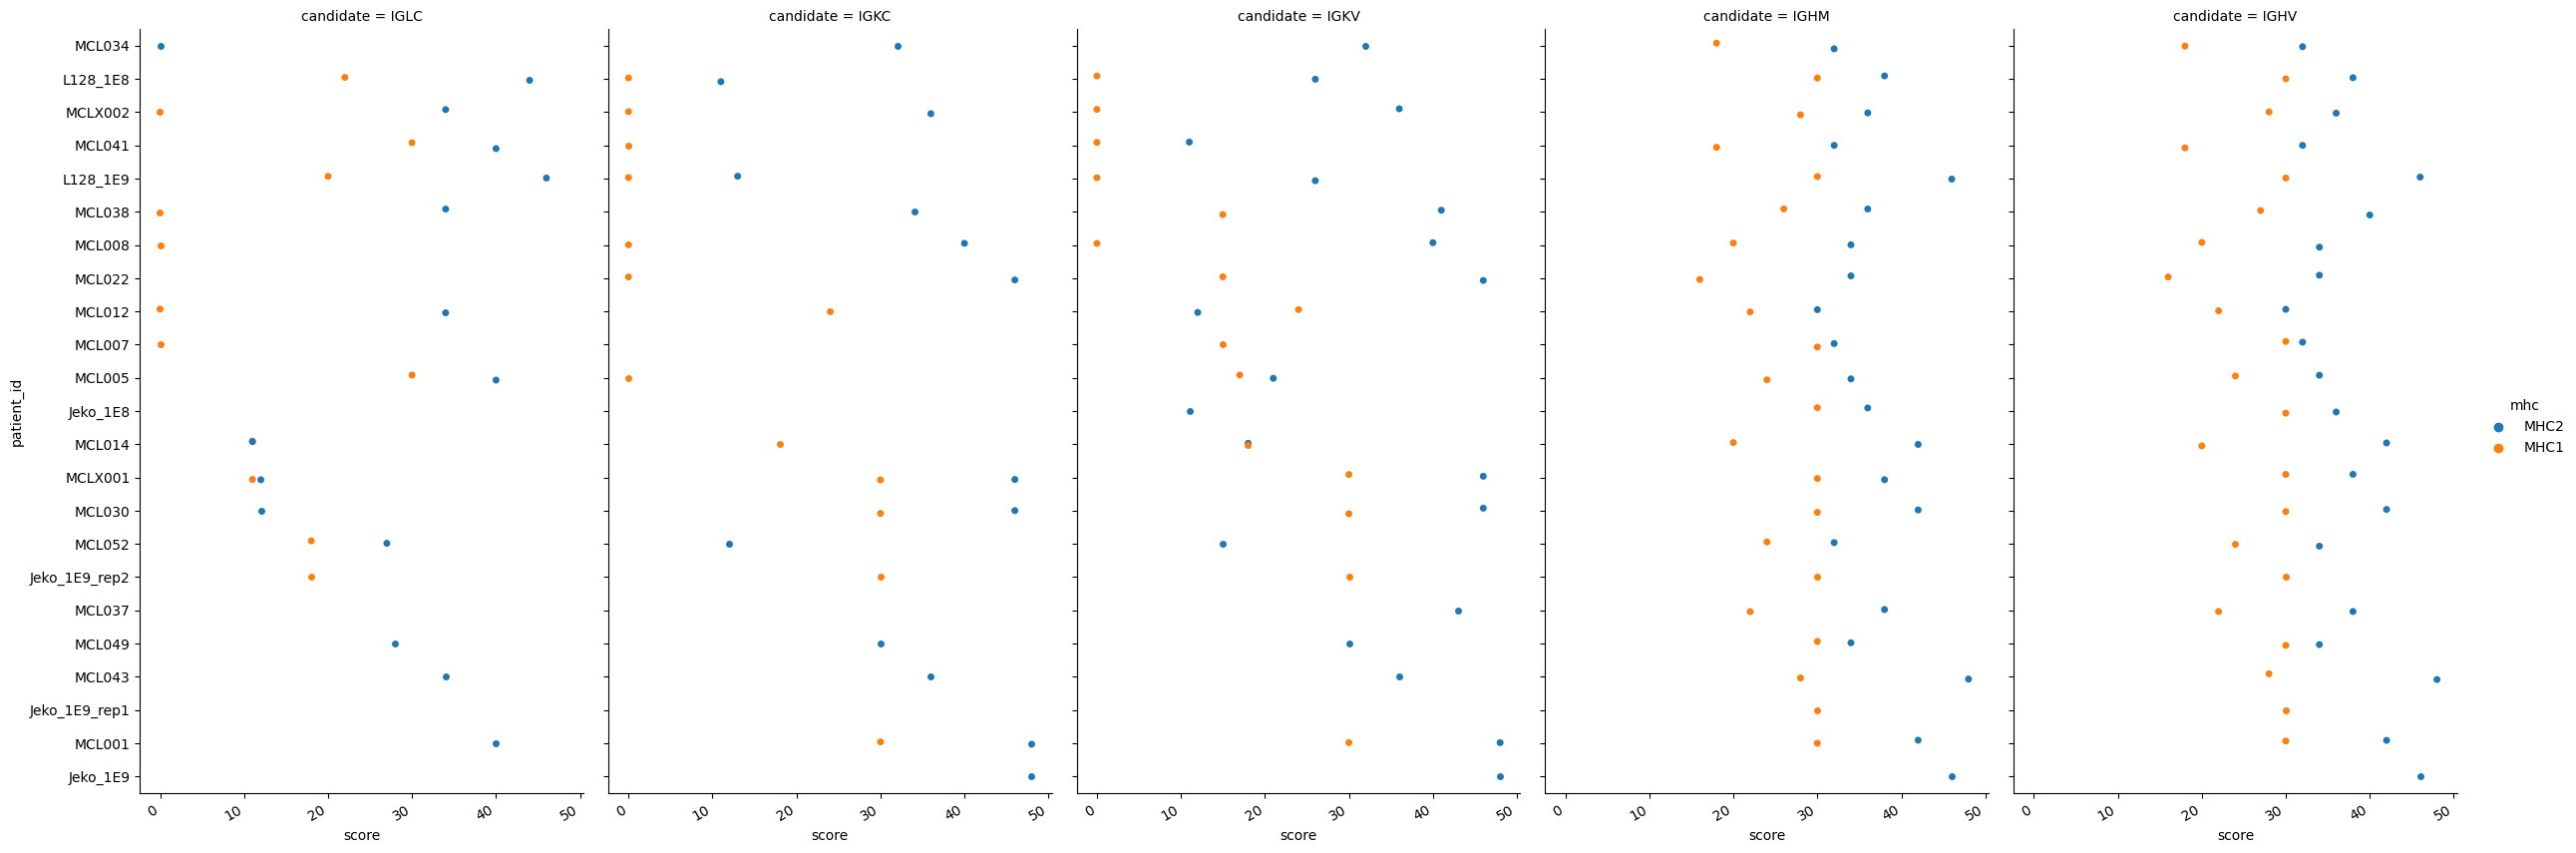

In [18]:
# Exclude alignments that are less than 8 amino acids long
candidate_df = patient_df.copy()
candidate_df.loc[candidate_df['length'] < 8, 'score'] = 0
candidate_df = candidate_df.sort_values(by='score')

plot = sns.catplot(
    candidate_df,
    y='patient_id',
    x='score',
    col='candidate',
    hue='mhc',
    aspect=0.5,
    height=10
)

import matplotlib.pyplot as plt
fig = plt.gcf()
fig.autofmt_xdate()

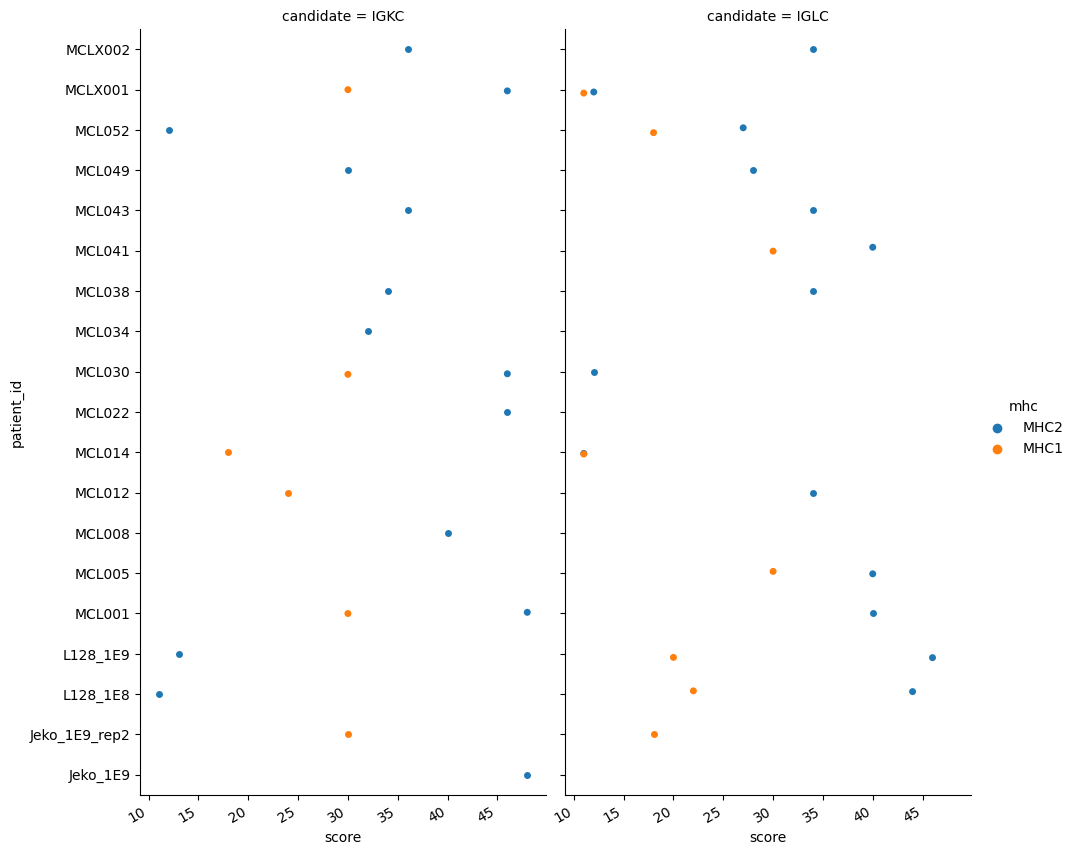

In [20]:
# We should always have a strong match for either lambda or kappa, hopefully not both.
candidate_df = patient_df.copy()
candidate_df = candidate_df[(candidate_df['candidate'] == 'IGKC') | (candidate_df['candidate'] == 'IGLC')]
candidate_df = candidate_df[candidate_df['length'] >= 8]
candidate_df = candidate_df.sort_values(by='patient_id', ascending=False)

plot = sns.catplot(
    candidate_df,
    x='score',
    y='patient_id',
    col='candidate',
    hue='mhc',
    aspect=0.5,
    height=10,
)

import matplotlib.pyplot as plt
fig = plt.gcf()
fig.autofmt_xdate()

In [11]:
diffs = {}

for patient_file in candidate_df['patient_file'].unique():
  pf = candidate_df[candidate_df['patient_file'] == patient_file]

  igkc_score = list(pf.loc[pf['candidate'] == 'IGKC']['score'])
  iglc_score = list(pf.loc[pf['candidate'] == 'IGLC']['score'])
  if igkc_score and iglc_score and igkc_score[0] > 0:
    diffs[patient_file] = np.abs(igkc_score[0] - iglc_score[0])

sorted(diffs.items(), key=lambda kv: kv[1])

[('MCL001_MHC2', 8.0)]

In [12]:
candidate_df[candidate_df['patient_file'] == 'MCL014_MHC1']

,patient_file,candidate,score,alignment,peptide,length,mhc
